# Exploring the Anomalies

This section is done in pandas because the resulting outlier datasets are very small

In [1]:
### ipyleaflet required to run the map codes in data exploration
# !pip install ipyleaflet

# Use these commands in terminal
### Install ipyleaflet:                conda install -c conda-forge ipyleaflet
### Install Node.js:                   conda install -c anaconda nodejs
### Install the JupyterLab extension:  jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# RUN THE FOLLOWING COMMAND IN JUPYTER TERMINAL
# jupyter labextension develop . --overwrite

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Matplotlib created a temporary cache directory at /tmp/matplotlib-u2ekq17o because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
%%time
### Load datasets

### Open the outlier datasets
pca_major = pd.read_csv("outliers/0_pca_major_outliers.csv", index_col=0)
pca_close = pd.read_csv("outliers/1_pca_close_outliers.csv", index_col=0)
iqr_outliers = pd.read_csv("outliers/2_IQR_outliers.csv", index_col=0)
std_outliers = pd.read_csv("outliers/3_STD_outliers.csv", index_col=0)
iforest_outliers = pd.read_csv("outliers/4_iforest_outliers.csv", index_col=0)

### For IQR and STD ONLY: Filter for only the low PC1 or PC2 outliers since those were most significant for both
iqr_outliers = iqr_outliers[(iqr_outliers["IQR_PC1_low"]==1) | (iqr_outliers["IQR_PC2_low"]==1)]
std_outliers = std_outliers[(std_outliers["STD_PC1_low"]==1) | (std_outliers["STD_PC2_low"]==1)]

### Filter the metadata for only the correct kwp systems
meta_filename = "metadata_preprocessed.csv"
df_meta = pd.read_csv(meta_filename)

high_kwp_cutoff = df_meta["kwp"].quantile(0.75)
low_kwp_cutoff = df_meta["kwp"].quantile(0.25)

df_meta = df_meta[(df_meta["kwp"]>low_kwp_cutoff) & (df_meta["kwp"]<high_kwp_cutoff)].reset_index(drop=True)

df_meta.describe()

CPU times: user 793 ms, sys: 115 ms, total: 908 ms
Wall time: 1.12 s


,ss_id,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,11917.000000,11917.000000,11917.000000,11917.000000,11917.000000,11917.000000
mean,14622.054880,52.881305,-1.415430,178.305782,31.594025,2.809018
std,6761.647032,1.454569,1.358153,47.652603,5.790324,0.303699
min,2405.000000,50.100000,-5.680000,0.000000,5.000000,2.289000
25%,9387.000000,51.890000,-2.390000,150.000000,30.000000,2.520000
50%,14451.000000,52.600000,-1.480000,180.000000,30.000000,2.800000
75%,19706.000000,53.480000,-0.260000,210.000000,35.000000,3.060000
max,26768.000000,58.150000,1.720000,350.000000,60.000000,3.400000


In [4]:
pca_major_meta = pd.merge(pca_major[["id", "ss_id", "stamp_date"]], df_meta, how="inner", on="ss_id")
pca_close_meta = pd.merge(pca_close, df_meta, how="inner", on="ss_id")
pca_outliers_meta = pd.concat([pca_major_meta, pca_close_meta], axis=0).reset_index(drop=True)

iqr_outliers_meta = pd.merge(iqr_outliers, df_meta, how="inner", on="ss_id")
std_outliers_meta = pd.merge(std_outliers, df_meta, how="inner", on="ss_id")

iforest_outliers_meta = pd.merge(iforest_outliers, df_meta, how="inner", on="ss_id")

In [5]:
### Filter iforest outliers for only those with scores below 0.6"
cutoff = 0.6
iforest_major_meta = iforest_outliers_meta[iforest_outliers_meta["score"] < cutoff]

In [6]:
# ### Split iforest_outliers_meta into close and major
# # Calculate Q1 - 1.5 * IQR
# Q1 = iforest_outliers_meta["score"].quantile(0.25)
# Q3 = iforest_outliers_meta["score"].quantile(0.75)
# cutoff = Q1 - 1.5 * (Q3-Q1)
# print(cutoff)

# iforest_close_meta = iforest_outliers_meta[iforest_outliers_meta["score"] >= cutoff]
# iforest_major_meta = iforest_outliers_meta[iforest_outliers_meta["score"] < cutoff]

In [7]:
### Set up function to plot histograms
def plot_hist(plot_df):
    # Setting up the gridspec subplots
    fig = plt.figure(figsize=(12,10))
    grid = plt.GridSpec(3,4, wspace=0.45, hspace=0.35)
    
    plot1 = fig.add_subplot(grid[0,1:3])
    plot2 = fig.add_subplot(grid[1,:2])
    plot3 = fig.add_subplot(grid[1,2:])
    plot4 = fig.add_subplot(grid[2,:2])
    plot5 = fig.add_subplot(grid[2,2:])
    
    plots = [plot1, plot2, plot3, plot4, plot5]
    cols = ["kwp", "latitude_rounded", "longitude_rounded", "orientation", "tilt"]
    titles = ["PV System Power Rating", "Latitude", "Longitude", "Panel Orientation", "Panel Tilt"]
    colors = ["r", "b", "g", "orange", "pink"]
    
    for i,(ax,col,title, color) in enumerate(zip(plots, cols, titles, colors)):
        sns.histplot(plot_df[col], ax=ax, bins=50, color=color)
        ax.set(xlabel="", title=title)

    return plots

def plot_hist2(plot_dfs, col, titles):
    ### Same as before, except show the result for several dfs on a single column
    # Setting up the gridspec subplots
    fig = plt.figure(figsize=(12,9))
    grid = plt.GridSpec(4,4, wspace=0.55, hspace=0.35, top=0.9)
    
    plot1 = fig.add_subplot(grid[0,1:3])
    plot2 = fig.add_subplot(grid[1,:2])
    plot3 = fig.add_subplot(grid[1,2:])
    plot4 = fig.add_subplot(grid[2,:2])
    plot5 = fig.add_subplot(grid[2,2:])
    # plot6 = fig.add_subplot(grid[3,:2])
    # plot7 = fig.add_subplot(grid[3,2:])
    
    plots = [plot1, plot2, plot3, plot4, plot5]#, plot6, plot7]
    colors = ["r", "b", "g", "orange", "pink"]#, "c", "brown"]

    # Get x axis limits from the first plot (the normal plot)
    xlim = (plot_dfs[0][col].min(), plot_dfs[0][col].max())
    
    for i,(ax, plot_df, title, color) in enumerate(zip(plots, plot_dfs, titles, colors)):
        sns.histplot(plot_df[col], ax=ax, bins=50, color=color)
        ax.set(xlabel="", title=title, xlim=xlim)
        ax.grid(axis="x")

    return plots

In [8]:
### Gather the variables together
plot_dfs = [df_meta, pca_outliers_meta, 
            iqr_outliers_meta, std_outliers_meta, 
            iforest_major_meta]
titles = ["All Systems", "PCA Only", 
          "IQR Method (Low PC1/PC2 Only)",
          "STD Method (Low PC1/PC2 Only)",
          f"I-Forest (Score < {np.round(cutoff, 3)})"]

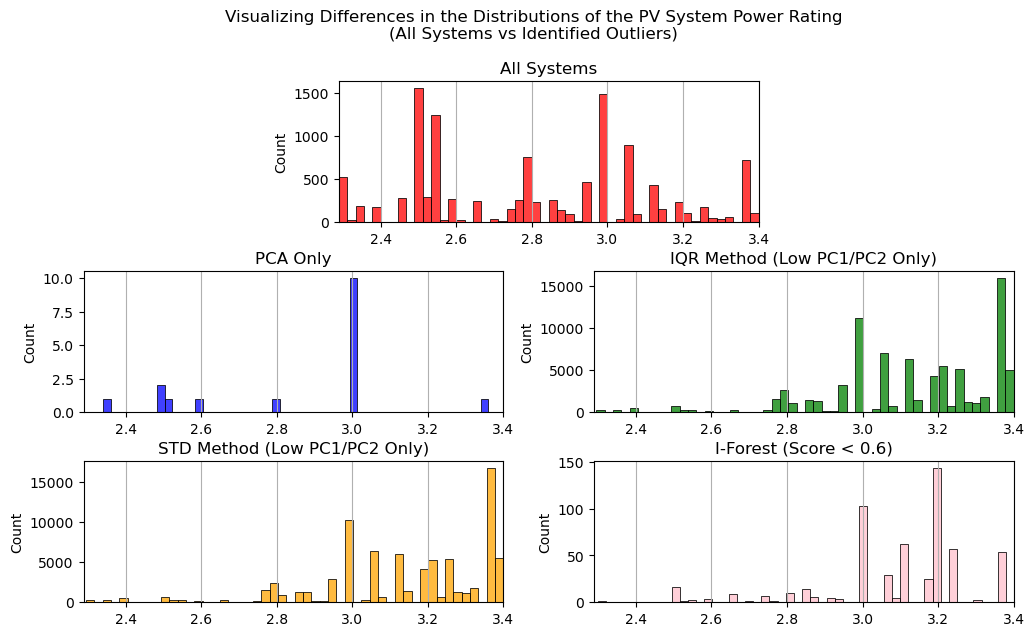

In [9]:
### Plotting histograms for each outlier group
col = "kwp"
col_title = "PV System Power Rating"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions of the {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

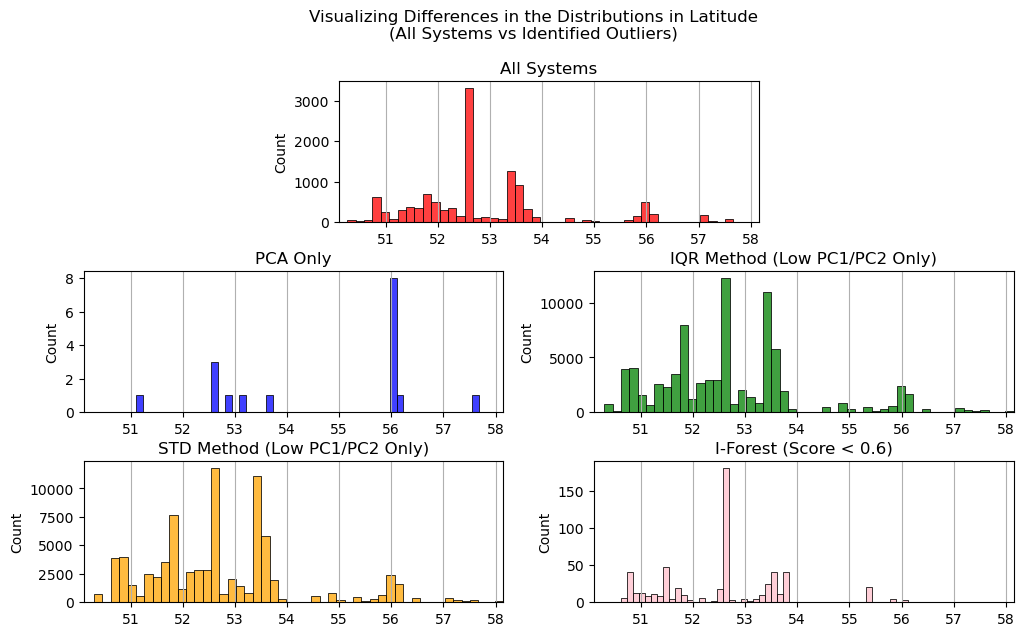

In [10]:
### Plotting histograms for each outlier group
col = "latitude_rounded"
col_title = "Latitude"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

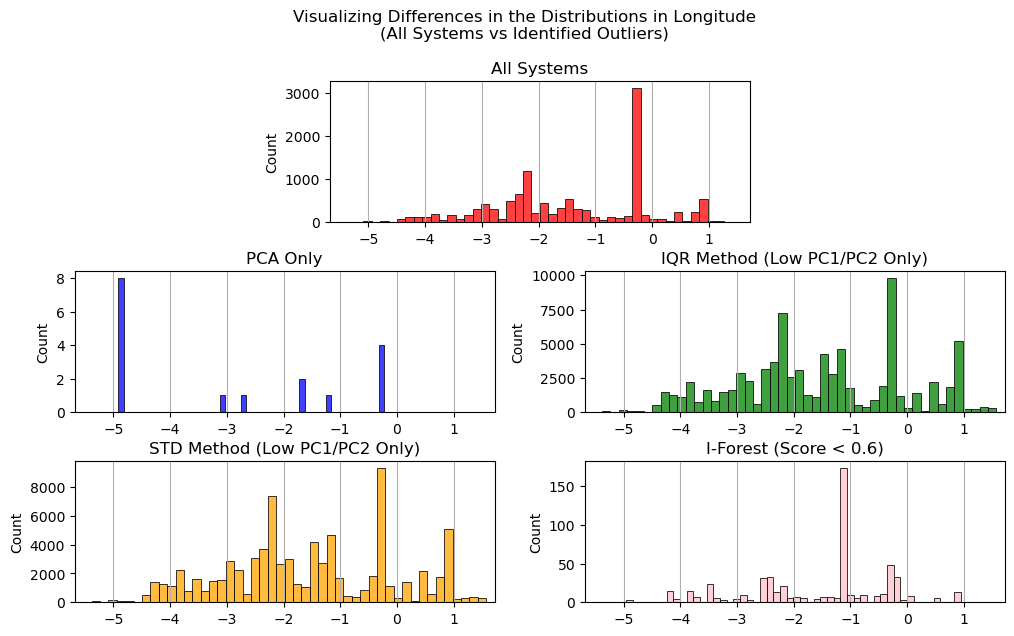

In [11]:
### Plotting histograms for each outlier group
col = "longitude_rounded"
col_title = "Longitude"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

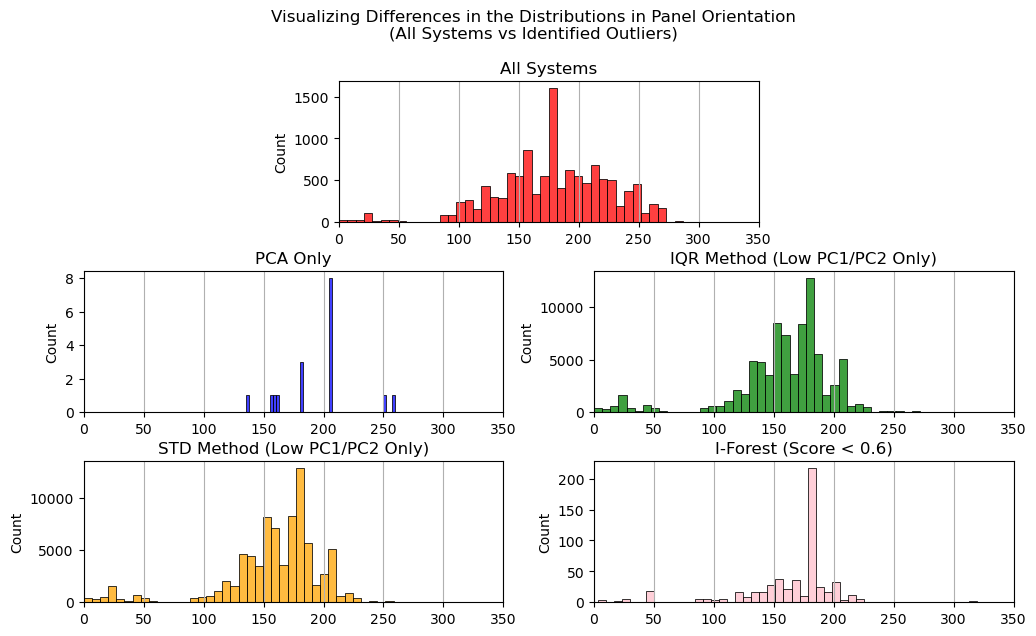

In [12]:
### Plotting histograms for each outlier group --> pca outliers
col = "orientation"
col_title = "Panel Orientation"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

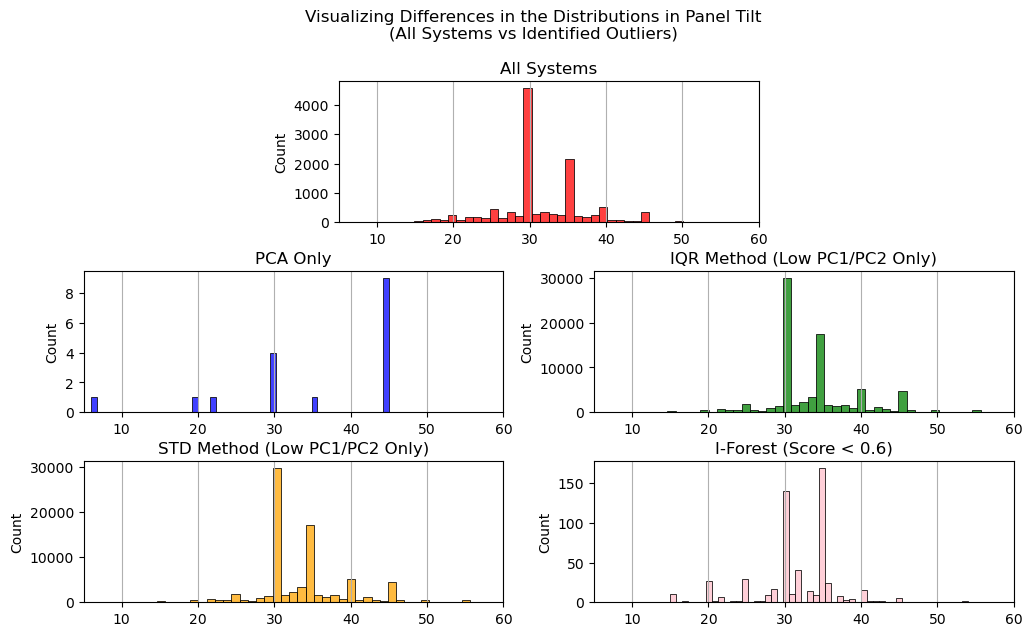

In [13]:
### Plotting histograms for each outlier group --> pca outliers
col = "tilt"
col_title = "Panel Tilt"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

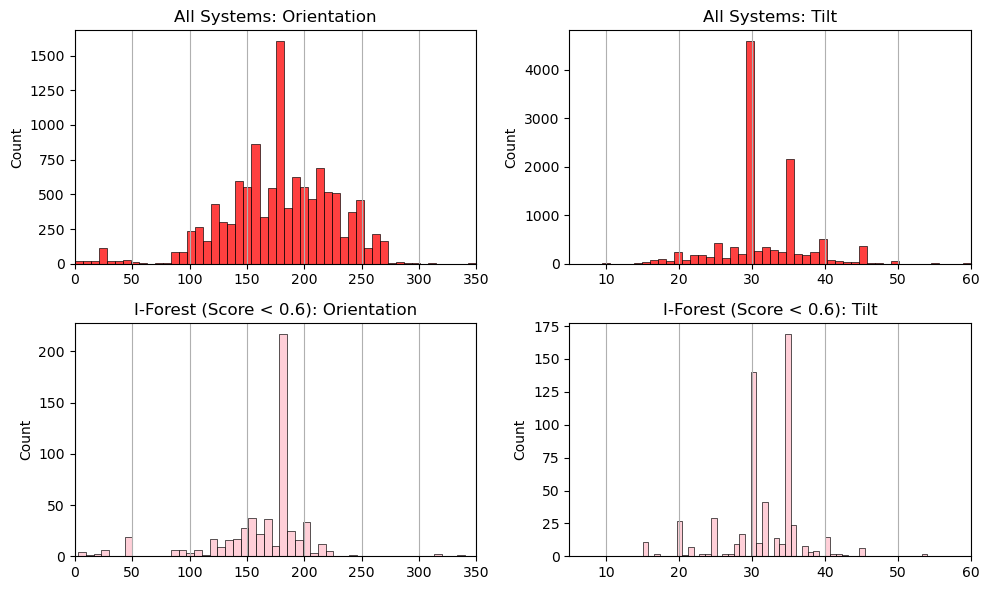

In [14]:
### Isolate all systems with Iforest for both orientation and tilt
fig,axes = plt.subplots(2,2, figsize=(10,6))
ax = axes.flatten()

#
df = df_meta
col = "orientation"
color = "r"
title = "All Systems: Orientation"
xlim = (df_meta[col].min(), df_meta[col].max())
sns.histplot(df[col], ax=ax[0], bins=50, color=color)
ax[0].set(xlabel="", title=title, xlim=xlim)
ax[0].grid(axis="x")
#
df = df_meta
col = "tilt"
color = "r"
title = "All Systems: Tilt"
xlim = (df_meta[col].min(), df_meta[col].max())
sns.histplot(df[col], ax=ax[1], bins=50, color=color)
ax[1].set(xlabel="", title=title, xlim=xlim)
ax[1].grid(axis="x")
#
df = iforest_major_meta
col = "orientation"
color = "pink"
title = "I-Forest (Score < 0.6): Orientation"
xlim = (df_meta[col].min(), df_meta[col].max())
sns.histplot(df[col], ax=ax[2], bins=50, color=color)
ax[2].set(xlabel="", title=title, xlim=xlim)
ax[2].grid(axis="x")
#
df = iforest_major_meta
col = "tilt"
color = "pink"
title = "I-Forest (Score < 0.6): Tilt"
xlim = (df_meta[col].min(), df_meta[col].max())
sns.histplot(df[col], ax=ax[3], bins=50, color=color)
ax[3].set(xlabel="", title=title, xlim=xlim)
ax[3].grid(axis="x")

plt.tight_layout()

In [15]:
### Exploring the major I-forest outliers more
iforest_major_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 21465 to 2053034
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 561 non-null    int64  
 1   ss_id              561 non-null    int64  
 2   stamp_date         561 non-null    object 
 3   score              561 non-null    float64
 4   latitude_rounded   561 non-null    float64
 5   longitude_rounded  561 non-null    float64
 6   llsoacd            561 non-null    object 
 7   orientation        561 non-null    float64
 8   tilt               561 non-null    float64
 9   kwp                561 non-null    float64
 10  operational_at     561 non-null    object 
dtypes: float64(6), int64(2), object(3)
memory usage: 52.6+ KB


In [16]:
count_ss_ids = len(iforest_major_meta["ss_id"].unique())
print("Number of unique ss_ids:", count_ss_ids)

Number of unique ss_ids: 245


In [17]:
### Plotting function

def map_by_column(df, color_col, size_col=None):
    ### Get main map variables
    min_lat, min_long = df["latitude_rounded"].min(), df["longitude_rounded"].min()
    max_lat, max_long = df["latitude_rounded"].max(), df["longitude_rounded"].max()
    #
    map_center = [np.mean([min_lat, max_lat]), np.mean([min_long, max_long])]
    zoom = 5
    ### Plot stations according to column
    m = ipy.Map( \
               basemap= ipy.basemaps.OpenStreetMap.Mapnik, \
               default_tiles= ipy.TileLayer(opacity=1.0), \
               center=map_center, \
               zoom=zoom \
              )
    # Get min/max values
    min_values = np.round(df[color_col].min(), 3)
    max_values = np.round(df[color_col].max(), 3)
    # Set up the colorbar
    colorbar_base = matplotlib.cm.cool(np.arange(0,1,0.005))[:, :3]
    colorbar_shaped = np.stack([colorbar_base]*5)
    xticks_scaled = (colorbar_shaped.shape[1] - min_values) / (max_values - min_values)
    plt.imshow(colorbar_shaped)
    plt.yticks(())
    plt.xticks((0, colorbar_shaped.shape[1]), [min_values, max_values])
    # Get each point as a circle colored by column values
    circles = []
    for i,row in df.sort_values(by=color_col, ascending=True).iterrows():
        latitude = row["latitude_rounded"]
        longitude = row["longitude_rounded"]
        value = row[color_col]
        scaled_value = (value - min_values) / (max_values - min_values)
        color = matplotlib.colors.rgb2hex(matplotlib.cm.cool(scaled_value))
        # Set size
        if size_col is None:
            radius = 10
        else:
            radius = int(np.exp((row[size_col] + 1.5)**3))
            # print(radius)
        
        c = ipy.Circle(location=(latitude, longitude), \
                      color = color, \
                      radius = radius, \
                      opacity = 0.7, \
                      fill_opacity = 0.7,\
                      fill_color = color \
                      )
        m += c

    return m

Plotting systems where the isolation forest outlier score was below 0.6

Colored by outlier score



Map(center=[53.26, -2.005], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

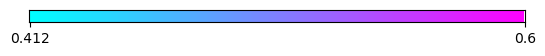

In [18]:
#%%time
print("Plotting systems where the isolation forest outlier score was below 0.6")
print()
print("Colored by outlier score")
print()

color_col = "score"
size_col = "score"
m = map_by_column(iforest_major_meta, color_col)

m

Plotting systems where the isolation forest outlier score was below 0.6

Colored by outlier score



Map(center=[53.26, -2.005], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

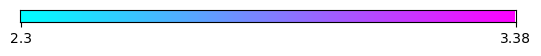

In [19]:
#%%time
print("Plotting systems where the isolation forest outlier score was below 0.6")
print()
print("Colored by outlier score")
print()

color_col = "kwp"
size_col = "score"
m = map_by_column(iforest_major_meta, color_col)

m

Plotting systems where the isolation forest outlier score was below 0.6

Colored by outlier score



Map(center=[53.26, -2.005], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

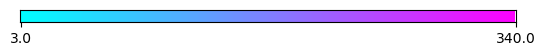

In [20]:
#%%time
print("Plotting systems where the isolation forest outlier score was below 0.6")
print()
print("Colored by outlier score")
print()

color_col = "orientation"
size_col = "score"
m = map_by_column(iforest_major_meta, color_col)

m

Plotting systems where the isolation forest outlier score was below 0.6

Colored by outlier score



Map(center=[53.26, -2.005], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

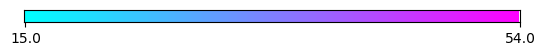

In [21]:
#%%time
print("Plotting systems where the isolation forest outlier score was below 0.6")
print()
print("Colored by outlier score")
print()

color_col = "tilt"
size_col = "score"
m = map_by_column(iforest_major_meta, color_col)

m